In [1]:
from table_creations import *
import requests
from credentials import config
from authentication import get_token
import pandas as pd
import time

In [2]:
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect() #Kan vel være et argument til funksjonen? Tenkte på dette

In [3]:
create_keyspace(session, keyspace='fish_data')
reset_table(session, keyspace='fish_space', table_name='localities')

In [4]:
create_locality_table(session)

In [5]:
from api_creations import *
df = api_weather_station_id(id = "SN65310", year="2022")
df.head()

,mean(air_temperature P1D),mean(wind_speed P1D),mean(relative_humidity P1D),week,year,referenceTime,sourceId
0,4.6,6.4,72,0,2022,2022-01-01T00:00:00.000Z,SN65310:0
0,4.0,10.2,86,0,2022,2022-01-02T00:00:00.000Z,SN65310:0
0,6.3,7.0,90,1,2022,2022-01-03T00:00:00.000Z,SN65310:0
0,3.3,6.6,77,1,2022,2022-01-04T00:00:00.000Z,SN65310:0
0,1.1,8.7,78,1,2022,2022-01-05T00:00:00.000Z,SN65310:0


In [6]:
def get_week_summary_locality(token, year, week, localityID):
  url = f"{config['api_base_url']}/v1/geodata/fishhealth/locality/{localityID}/{year}/{week}"
  headers ={
    'authorization': 'Bearer ' + token['access_token'],
    'content-type': 'application/json',
  }

  response = requests.get(url, headers=headers)
  response.raise_for_status()
  return response.json()  

In [7]:
def get_week_summary(token, year, week):
  url = f"{config['api_base_url']}/v1/geodata/fishhealth/locality/{year}/{week}"
  headers ={
    'authorization': 'Bearer ' + token['access_token'],
    'content-type': 'application/json',
  }

  response = requests.get(url, headers=headers)
  response.raise_for_status()
  return response.json()
import time

In [8]:
token = get_token()
year = 2022
localityNo = 30977
#Kepp these values year INT,

values_to_keep = ["week", "year", "localityNo", "avgAdultFemaleLice", "hasReportedLice", "avgMobileLice", "avgStationaryLice", "seaTemperature"]

Token request successful


In [9]:

from table_creations import *
from api_creations import *
from use_spark import *
localityNo = 30977

In [10]:
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect() #Kan vel være et argument til funksjonen? Tenkte på dette

In [11]:
token = get_token()
df_locality = pd.DataFrame()
for week in range(1, 53):
    row = {}
    locality_data = get_week_summary_locality(token, year, week, localityNo)
    row["localityname"] = locality_data["localityName"]
    for val in values_to_keep:
        row[val.lower()] = locality_data["localityWeek"][val]
    df_locality = pd.concat([df_locality, pd.DataFrame([row])], ignore_index=True)

Token request successful


/tmp/ipykernel_12431/3690007368.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_locality = pd.concat([df_locality, pd.DataFrame([row])], ignore_index=True)


In [12]:
print(locality_data["ilaSurveillanceZones"])

[]


In [13]:
create_localities_table(session, locality_id = localityNo)

In [14]:
spark = initiate_spark()

your 131072x1 screen size is bogus. expect trouble
23/11/29 15:38:24 WARN Utils: Your hostname, Ivars-PC resolves to a loopback address: 127.0.1.1; using 172.23.6.83 instead (on interface eth0)
23/11/29 15:38:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/ivholmlu/.local/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ivholmlu/.ivy2/cache
The jars for the packages stored in: /home/ivholmlu/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3c7ef5f8-452d-40d8-b7ce-4674eb82647d;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.4.1 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.4.1 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.11.0 in central
	found com.datastax.oss#java-driver-core-shaded;4.13.0 in central
	found com.datastax.oss#native-protocol;1.5.0 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0

In [15]:
df_locality.head()

,localityname,week,year,localityno,avgadultfemalelice,hasreportedlice,avgmobilelice,avgstationarylice,seatemperature
0,Æsøya,1,2022,30977,0.00,True,0.10,0.05,4.0
1,Æsøya,2,2022,30977,0.01,True,0.12,0.07,4.9
2,Æsøya,3,2022,30977,0.00,True,0.10,0.05,5.2
3,Æsøya,4,2022,30977,0.00,True,0.02,0.00,5.0
4,Æsøya,5,2022,30977,NaN,False,NaN,NaN,3.8


In [16]:
def insert_into_locality(spark, locality_id, df, keyspace="fish_data"):
    #make spark dataframe from df
    spark_df = spark.createDataFrame(df)
    spark_df.write\
        .format("org.apache.spark.sql.cassandra")\
        .mode('append')\
        .options(table=f"locality_{locality_id}", keyspace=keyspace)\
        .save()

In [17]:
insert_into_locality(spark, localityNo, df_locality)

/home/ivholmlu/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [18]:
def get_locality_table(session, locality_id, keyspace="fish_data"):
    #Return as pandas dataframe

    query = f"SELECT * FROM {keyspace}.locality_{locality_id}"
    df = pd.DataFrame(list(session.execute(query)))
    return df

In [19]:
df_locality = get_locality_table(session, locality_id=localityNo)
df_locality.head()

,year,week,localityno,avgadultfemalelice,avgmobilelice,avgstationarylice,hasreportedlice,lat,localityname,lon,seatemperature
0,2022,1,30977,0.00,0.10,0.05,True,None,Æsøya,None,4.0
1,2022,2,30977,0.01,0.12,0.07,True,None,Æsøya,None,4.9
2,2022,3,30977,0.00,0.10,0.05,True,None,Æsøya,None,5.2
3,2022,4,30977,0.00,0.02,0.00,True,None,Æsøya,None,5.0
4,2022,5,30977,NaN,NaN,NaN,False,None,Æsøya,None,3.8


<Axes: >

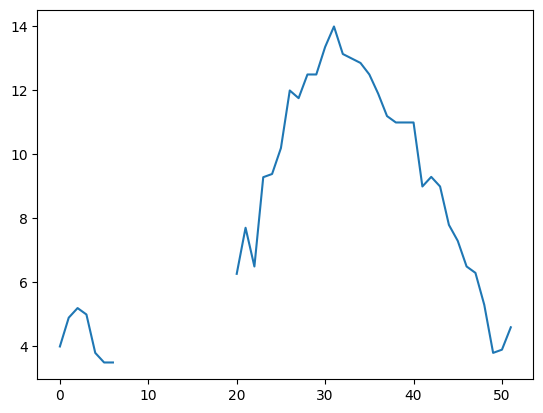

In [20]:
df_locality["seatemperature"].plot()

In [21]:
def create_locality_table(session):
    session.execute(f"DROP TABLE IF EXISTS locality_data")
    table_creation_query = """CREATE TABLE IF NOT EXISTS locality_data (
    year INT,
    week INT,
    localityno INT,
    localityweekid INT,
    name TEXT,
    hasreportedlice BOOLEAN,
    isfallow BOOLEAN,
    avgadultfemalelice DOUBLE,
    hascleanerfishdeployed BOOLEAN,
    hasmechanicalremoval BOOLEAN,
    hassubstancetreatments BOOLEAN,
    haspd BOOLEAN,
    hasila BOOLEAN,
    municipalityno TEXT,
    municipality TEXT,
    lat DOUBLE,
    lon DOUBLE,
    isonland BOOLEAN,
    infilteredselection BOOLEAN,
    hassalmonoids BOOLEAN,
    isslaughterholdingcage BOOLEAN,
    PRIMARY KEY (year, week, localityno)
);"""
    session.execute(table_creation_query)

In [22]:
def localities_api(year):
    list_localitites = []
    df_total = pd.DataFrame()
    for week in range(1, 53):
        locality_data = get_week_summary(token, year, week)
        for row in locality_data["localities"]:
            row["year"] = locality_data["year"]
            row["week"] = locality_data["week"]
            list_localitites.append(row)
    df_localities_year = pd.DataFrame(list_localitites)
    df_localities_year.columns = df_localities_year.columns.str.lower()
    return df_localities_year

In [23]:
create_locality_table(session)

In [24]:
df = localities_api(2022)

In [25]:
df.columns

Index(['localityno', 'localityweekid', 'name', 'hasreportedlice', 'isfallow',
       'avgadultfemalelice', 'hascleanerfishdeployed', 'hasmechanicalremoval',
       'hassubstancetreatments', 'haspd', 'hasila', 'municipalityno',
       'municipality', 'lat', 'lon', 'isonland', 'infilteredselection',
       'hassalmonoids', 'isslaughterholdingcage', 'year', 'week'],
      dtype='object')

In [26]:
def insert_localities_year(spark, df, keyspace="fish_data"):
    spark_df = spark.createDataFrame(df)
    spark_df.write\
        .format("org.apache.spark.sql.cassandra")\
        .mode('append')\
        .options(table=f"locality_data", keyspace=keyspace)\
        .save()

In [27]:
insert_localities_year(spark, df)

/home/ivholmlu/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [28]:
def get_lat_lon(session, locality_id):
    session.set_keyspace('fish_data')
    query = f"SELECT lat, lon FROM locality_data WHERE year = 2022 AND week = 1 AND localityno = {locality_id}"
    result = session.execute(query)
    print(result)
    for row in result:
        lat = row.lat
        lon = row.lon
    return lat, lon

In [29]:
localityNo = 30977
loc = get_lat_lon(session, localityNo)

In [32]:
from credentials import config_frost

(68.104867, 13.790067)

In [37]:
#Find id for weather station based on lat and lon from df localitites.

def finding_closest_station(coordinates):
    location_lat, location_lon = coordinates
    endpoint = 'https://frost.met.no/sources/v0.jsonld'

    parameters = {
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D)',
    "geometry": f'nearest(POINT({location_lon} {location_lat}))',
    "nearestmaxcount": 3,}
    
    r = requests.get(endpoint, parameters, auth=(config_frost["client_id"],''))
    # Extract JSON data
    json = r.json()

    return json

In [38]:
a = finding_closest_station(loc)

{'@context': 'https://frost.met.no/schema',
 '@type': 'SourceResponse',
 'apiVersion': 'v0',
 'license': 'https://creativecommons.org/licenses/by/3.0/no/',
 'createdAt': '2023-11-29T14:45:18Z',
 'queryTime': 2.319,
 'currentItemCount': 3,
 'itemsPerPage': 3,
 'offset': 0,
 'totalItemCount': 3,
 'currentLink': 'https://frost.met.no/sources/v0.jsonld?elements=mean%28air_temperature+P1D%29%2Csum%28precipitation_amount+P1D%29%2Cmean%28wind_speed+P1D%29&geometry=nearest%28POINT%2813.790067+68.104867%29%29&nearestmaxcount=3',
 'data': [{'@type': 'SensorSystem',
   'id': 'SN85560',
   'name': 'LEKNES LUFTHAVN',
   'shortName': 'Leknes LH',
   'country': 'Norge',
   'countryCode': 'NO',
   'wmoId': 1141,
   'geometry': {'@type': 'Point',
    'coordinates': [13.615, 68.155],
    'nearest': False},
   'distance': 9.146457727520001,
   'masl': 26,
   'validFrom': '1972-06-01T00:00:00.000Z',
   'county': 'NORDLAND',
   'countyId': 18,
   'municipality': 'VESTVÅGØY',
   'municipalityId': 1860,
   '

In [45]:
id = a["data"][0]['id']

endpoint = 'https://frost.met.no/observations/v0.jsonld'
parameters = {
    'sources': f'{id}',
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D), mean(relative_humidity P1D)',
    'referencetime': f'{year}-01-01/{year+1}-01-01'}
r = requests.get(endpoint, parameters, auth=(config_frost["client_id"],''))

json = r.json()

In [46]:
json

{'@context': 'https://frost.met.no/schema',
 '@type': 'ObservationResponse',
 'apiVersion': 'v0',
 'license': 'https://creativecommons.org/licenses/by/3.0/no/',
 'createdAt': '2023-11-29T14:49:50Z',
 'queryTime': 0.539,
 'currentItemCount': 365,
 'itemsPerPage': 365,
 'offset': 0,
 'totalItemCount': 365,
 'currentLink': 'https://frost.met.no/observations/v0.jsonld?sources=SN85560&elements=mean%28air_temperature+P1D%29%2Csum%28precipitation_amount+P1D%29%2Cmean%28wind_speed+P1D%29%2C+mean%28relative_humidity+P1D%29&referencetime=2022-01-01%2F2023-01-01',
 'data': [{'sourceId': 'SN85560:0',
   'referenceTime': '2022-01-01T00:00:00.000Z',
   'observations': [{'elementId': 'mean(air_temperature P1D)',
     'value': -5.4,
     'unit': 'degC',
     'level': {'levelType': 'height_above_ground', 'unit': 'm', 'value': 2},
     'timeOffset': 'PT0H',
     'timeResolution': 'P1D',
     'timeSeriesId': 0,
     'performanceCategory': 'C',
     'exposureCategory': '2',
     'qualityCode': 0},
    {'e